# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
import ast
from ast import List
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
#| export
def boltzmann(energies):
    q=list()
    e_offset=min(energies)
    for i in energies:
        q.append(np.exp((i-e_offset)/(8.31446261815324/1000*298.15)))
    q_sum=sum(q)
    dist=list()
    for i in q:
        prob=i/q_sum
        dist.append(prob)
    return dist


def set_x_spacing(plot_range_max, plot_range_min, wave_number_spacing):
    remainder=(plot_range_max-plot_range_min)%wave_number_spacing
    if remainder==0:
        npoints=int((plot_range_max-plot_range_min)//wave_number_spacing+1)
    if remainder!=0:
        npoints=int((plot_range_max-plot_range_min)//wave_number_spacing+2)
    xs=np.linspace(plot_range_min,plot_range_max,npoints)
    return xs


def fixed_var_spectrum(frequencies,intensities,xs,fixed_var):
    ys=np.empty((0,len(xs)))
    for i in range(len(frequencies)):
        y=intensities[i]/(2*np.pi*fixed_var)**0.5*np.exp(-(xs-frequencies[i])**2/(2*fixed_var))
        if frequencies[i]==0.00:
            y=y*0.0
        y=np.expand_dims(y,axis=0)
        ys=np.append(ys,y,axis=0)
    spectrum_data=ys.sum(axis=0)
    return spectrum_data


def norm_integration(spectra_sum, xs, norm_range_min, norm_range_max):
    norm_factor=sum([j for i,j in enumerate(spectra_sum) if xs[i]>=norm_range_min and xs[i]<norm_range_max])
    norm_spectrum=spectra_sum/norm_factor
    return norm_spectrum

def pytorch_model_spectrum(frequencies,intensities,xs,model):
    peaks=torch.zeros([len(frequencies),1801])
    for e,i in enumerate(frequencies):
        peaks[e,:int(i//2-199)]=1
        if i < 4000: peaks[e,int(i//2-199)]=i%2/2
    weights=torch.tensor(intensities)
    peaks=model(peaks)
    peaks=torch.exp(peaks)
    weights=torch.unsqueeze(weights,dim=1)
    peaks=torch.mul(peaks,weights)
    output=torch.sum(peaks,dim=0)
    return output.data.numpy()

def load_pytorch_model(model_path):
    state=torch.load(model_path,map_location=torch.device('cpu'))
    w0=state['state_dict']['peaknn.0.weight']
    b0=state['state_dict']['peaknn.0.bias']
    w2=state['state_dict']['peaknn.2.weight']
    b2=state['state_dict']['peaknn.2.bias']
    torch.set_default_dtype(torch.double)
    L0=torch.nn.Linear(1801,2200)
    L0.weight=torch.nn.Parameter(w0)
    L0.bias=torch.nn.Parameter(b0)
    L1=torch.nn.ReLU()
    L2=torch.nn.Linear(2200,1801)
    L2.weight=torch.nn.Parameter(w2)
    L2.bias=torch.nn.Parameter(b2)
    model=torch.nn.Sequential(L0,L1,L2)
    for param in model.parameters():
        param.requires_grad=False
    return model

In [ ]:
#| export
def generate_spectrums(df: pd.DataFrame) -> list[np.array]:

    xs = set_x_spacing(4000, 400, 2)
    model = load_pytorch_model('../data/model19.pt')
    outputs = []
    for i in tqdm(range(0, len(df["Intensity"])), desc="Generating Spectrums"):
        freq = np.array(df["ScaledFreq [cm-1]"][i])
        intensity = np.array(df["Intensity"][i])

        output = pytorch_model_spectrum(freq,intensity,xs)
        outputs.append(output)
    return outputs

In [ ]:
#| export
def prepare_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fix columns and datatypes so the freq and intensity values can be accessed.
    """
    df['RawFreq [cm-1]'] =df['RawFreq [cm-1]'].str.replace('"', '')

    df['RawFreq [cm-1]'] =df['RawFreq [cm-1]'].apply(ast.literal_eval)
    df['ScaledFreq [cm-1]'] =df['ScaledFreq [cm-1]'].apply(ast.literal_eval)
    df['Intensity'] =df['Intensity'].apply(ast.literal_eval)
    df =df.map(lambda x: [float(i) for i in x] if isinstance(x, list) else x)
    return df

In [ ]:
#| export
def prepare_processed_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates final processed dataset with broaden spectrum values and a column for the associated SMILES string.

    Parameters:
        df: DataFrame containing the SMILES strings and the raw frequency and intensity values.

    Returns:
        DataFrame containing the SMILES strings and the processed spectrum values.

    """

    outputs = generate_spectrums(df)
    # Create a list of column names
    cols = list(range(4000, 398, -2))

    # Create an empty DataFrame with the specified column names
    processed_df = pd.DataFrame(columns=cols)

    for i, arr in enumerate(outputs):
        processed_df.loc[i] = arr

    processed_df = pd.concat([processed_df, df["SMILES"]], axis=1)
    processed_df = pd.concat([processed_df, df["IUPAC_chemname"]], axis=1)    
    return processed_df


Generating Spectrums:   2%|▏         | 60/2743 [00:05<04:23, 10.19it/s]


KeyboardInterrupt: 

<BarContainer object of 3 artists>

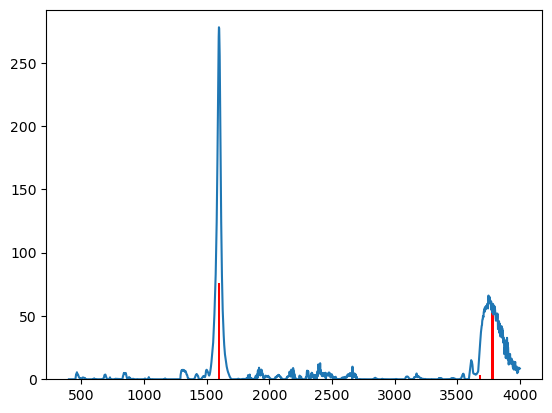

In [ ]:
frequencies = np.array([1598.0372406800595, 3682.1786484947465, 3780.8505903567507])
intensities = np.array([76.3428, 3.6852, 57.5517])

xs = np.arange(400,4002,2)
output = pytorch_model_spectrum(frequencies,intensities,xs)

plt.plot(xs, output)
plt.bar(frequencies, intensities, width=20, color="red")